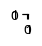

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [2]:
# Load models together
from src.torch_utils import load_model_full
from src.metrics import compute_cosine_distance
from src.utils import get_class_initcode_keys
from src.models import BimodalVAEClassifier, FullTCRVAE, PeptideClassifier
from src.datasets import BimodalTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
pos_df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
mix_df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')


def get_model(folder):
    pt = glob.glob(folder+'/*.pt')[0]
    js = glob.glob(folder+'/*.json')[0]
    model = load_model_full(pt, js, return_json=False, verbose=False)
    return model
    

# Redefine multimodal as : Pep - TCR:Pep - TCR

For full TCR ; 

- TCR with no pep can be healthy negatives for example
- Pep with no TCR can be from IEDB for example...

In [135]:
import glob
tcrpep_df = pd.read_csv('../data/filtered/231212_nettcr_expanded_pairedAB_412peps_with_swaps.csv').assign(db='nettcr').query('not origin.str.contains("swapped")')
tcr_df = pd.concat([pd.read_csv(x, sep='\t') for x in glob.glob('../data/immrep/*.tsv')]).assign(db='immrep_negs')
tcr_df = tcr_df[['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'db']].assign(peptide='XXXXXXXXX')


df = tcrpep_df.query('origin!="peptide_swapped" and input_type=="paired"')
df['peplen'] = df['peptide'].apply(len)
fracdict = (df.groupby('peplen').agg(count=('B3','count')) / len(df)).to_dict()['count']

randompeps = pd.concat([pd.read_csv(x, header=None, names=['peptide']) for x in glob.glob('../data/multimodal/randompeps/*randompeps_*.pep')])
randompeps['len'] = randompeps['peptide'].apply(len)
sample = randompeps.groupby('len', group_keys=False).apply(lambda x: x.sample(frac=fracdict[x.len.unique()[0]], random_state=13))
sample.to_csv('../data/multimodal/randompeps_8_12_lenSampled_1M.txt', index=False)

# Maybe use some of our neoepitope and viral and human peptides from CEDAR + PRIME + IEDB + NEPDB etc
viral = pd.read_csv('../../cedar_icerfire/data/heli_viral', sep =' ', usecols=['Icore', 'Rnk_EL', 'allele', 'id', 'uniprot_id', 'target', 'peptide_length', 'prot_sequence', 'peptide_start'])
human = pd.read_csv('../../cedar_icerfire/data/human_proteome/human_sample_100k.csv')
cedar = pd.read_csv('../../cedar_icerfire/data/aligned_icore/230418_cedar_aligned.csv')
prime = pd.read_csv('../../cedar_icerfire/data/aligned_icore/230418_prime_aligned.csv')
nepdb = pd.read_csv('../../cedar_icerfire/data/aligned_icore/230418_nepdb_aligned.csv')
viral = viral.rename(columns={'Icore':'peptide', 'Rnk_EL':'EL_rank',
              'peptide_length':'peplen', 'allele':'HLA'})\
             .assign(db='viral', input_type='peptide')\
             .drop(columns=['prot_sequence','id'])[['peptide','HLA','target','EL_rank', 'peplen','db','uniprot_id','peptide_start']]
human = human[['icore_mut','HLA', 'EL_rank_mut']].rename(columns={'icore_mut':'peptide', 'EL_rank_mut':'EL_rank'}).assign(target=0).assign(db='human', input_type='peptide')
cedar = cedar[['icore_mut','HLA', 'EL_rank_mut', 'agg_label']].rename(columns={'icore_mut':'peptide', 'EL_rank_mut':'EL_rank', 'agg_label':'target'}).assign(db='cedar', input_type='peptide')
prime = prime[['icore_mut','HLA', 'EL_rank_mut', 'agg_label']].rename(columns={'icore_mut':'peptide', 'EL_rank_mut':'EL_rank', 'agg_label':'target'}).assign(db='prime', input_type='peptide')
nepdb = nepdb[['icore_mut','HLA', 'EL_rank_mut', 'agg_label']].rename(columns={'icore_mut':'peptide', 'EL_rank_mut':'EL_rank', 'agg_label':'target'}).assign(db='nepdb', input_type='peptide')

peptide_data = pd.concat([viral, human, cedar, prime, nepdb]).assign(input_type='peptide')
peptide_data = peptide_data.drop_duplicates(['peptide'])
peptide_data['peplen'] = peptide_data['peptide'].apply(len)
peptide_data.to_csv('../data/multimodal/240311_merged_peptides.csv', index=False)
tcr_df.to_csv('../data/multimodal/240311_immrepnegs_tcrs.csv', index=False)
tcrpep_df.to_csv('../data/multimodal/240311_nettcr_pairedAB_expanded_noswap.csv', index=False)

In [141]:
multimodal_df = pd.concat([tcrpep_df.assign(input_type='tcr_pep'), 
                           peptide_data.assign(input_type='pep'), 
                           tcr_df.assign(input_type='tcr')])[['peptide', 'A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'allele', 'binder', 'target', 'partition', 'input_type', 'db']]
multimodal_df.to_csv('../data/multimodal/240311_multimodal_tcr_pep.csv', index=False)

In [148]:
multimodal_df['A1'].fillna('X'*7, inplace=True)
multimodal_df['A2'].fillna('X'*8, inplace=True)
multimodal_df['A3'].fillna('X'*22, inplace=True)
multimodal_df['B1'].fillna('X'*6, inplace=True)
multimodal_df['B2'].fillna('X'*7, inplace=True)
multimodal_df['B3'].fillna('X'*23, inplace=True)

In [150]:
multimodal_df.to_csv('../data/multimodal/240311_multimodal_tcr_pep.csv', index=False)
multimodal_df.query('db!="human"').to_csv('../data/multimodal/240311_multimodal_NO_HUMAN_tcr_pep.csv', index=False)

In [151]:
multimodal_df.groupby('input_type').count()

,peptide,A1,A2,A3,B1,B2,B3,allele,binder,target,partition,db
input_type,,,,,,,,,,,,
pep,121997,121997,121997,121997,121997,121997,121997,0,0,121997,0,121997
tcr,15957,15957,15957,15957,15957,15957,15957,0,0,0,0,15957
tcr_pep,9769,9769,9769,9769,9769,9769,9769,9769,9769,0,9769,9769


In [153]:
multimodal_df.query('db!="human"').groupby('input_type').count()

,peptide,A1,A2,A3,B1,B2,B3,allele,binder,target,partition,db
input_type,,,,,,,,,,,,
pep,13639,13639,13639,13639,13639,13639,13639,0,0,13639,0,13639
tcr,15957,15957,15957,15957,15957,15957,15957,0,0,0,0,15957
tcr_pep,9769,9769,9769,9769,9769,9769,9769,9769,9769,0,9769,9769


In [154]:
len(multimodal_df), len(multimodal_df.query('db!="human"'))

(147723, 39365)

# Define supervision level as % paired data vs total & deal with batching ?

In [160]:
multimodal_df.input_type.unique()

array(['tcr_pep', 'pep', 'tcr'], dtype=object)

In [156]:
data_size = 16000
n_sample = 10000

indices = torch.randperm(data_size)
sampled_indices = indices[:n_sample]
sampled_indices, len(sampled_indices.unique())

(tensor([ 4150, 15840, 14944,  ...,  1427, 13464,  7171]), 10000)

In [163]:
x = torch.empty([100, 78, 20])
x[:, :60, : ].shape

torch.Size([100, 60, 20])

In [186]:
torch.randperm(100)[:10]

tensor([78, 90, 84,  8, 69, 55, 67, 48, 64, 15])

In [203]:
from src.datasets import MultimodalPepTCRDataset
from torch.utils.data import SequentialSampler
ds = MultimodalPepTCRDataset(multimodal_df.query('db!="human"'))
dl = ds.get_dataloader(1024, SequentialSampler)
for b in dl:
    pass

In [206]:
b[0][:10]

tensor([[[  0.,  -1.,   0.,  ...,  -3.,  -2.,   0.],
         [ -1.,  -4.,  -3.,  ...,  -3.,  -1.,   4.],
         [  1.,  -1.,   1.,  ...,  -4.,  -2.,  -2.],
         ...,
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.]],

        [[  0.,  -1.,   0.,  ...,  -3.,  -2.,   0.],
         [  1.,  -1.,   1.,  ...,  -4.,  -2.,  -2.],
         [  0.,  -3.,   0.,  ...,  -3.,  -3.,  -4.],
         ...,
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.]],

        [[  0.,  -1.,   0.,  ...,  -3.,  -2.,   0.],
         [  1.,  -1.,   1.,  ...,  -4.,  -2.,  -2.],
         [ -1.,   0.,   0.,  ...,  -3.,  -2.,  -3.],
         ...,
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.]],

In [195]:
ds.tcr_indices

tensor([15875,  5716, 10470,  ...,  9178, 14856,  1519])

In [207]:
ds.increment_counter()
ds.tcr_indices
for b1 in dl:
    pass

In [209]:
b1[0][:10]

tensor([[[ -2.,  -2.,   2.,  ...,  -5.,  -3.,  -4.],
         [  1.,  -1.,   1.,  ...,  -4.,  -2.,  -2.],
         [  5.,  -2.,  -1.,  ...,  -3.,  -2.,   0.],
         ...,
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.]],

        [[  0.,  -3.,  -3.,  ...,  -3.,  -1.,   5.],
         [  1.,  -1.,   1.,  ...,  -4.,  -2.,  -2.],
         [  0.,  -3.,   0.,  ...,  -3.,  -3.,  -4.],
         ...,
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.]],

        [[  0.,  -1.,   0.,  ...,  -3.,  -2.,   0.],
         [ -2.,   7.,  -1.,  ...,  -3.,  -1.,  -3.],
         [ -2.,  -2.,   2.,  ...,  -5.,  -3.,  -4.],
         ...,
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.]],